In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import celerite
import emcee

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=False)
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


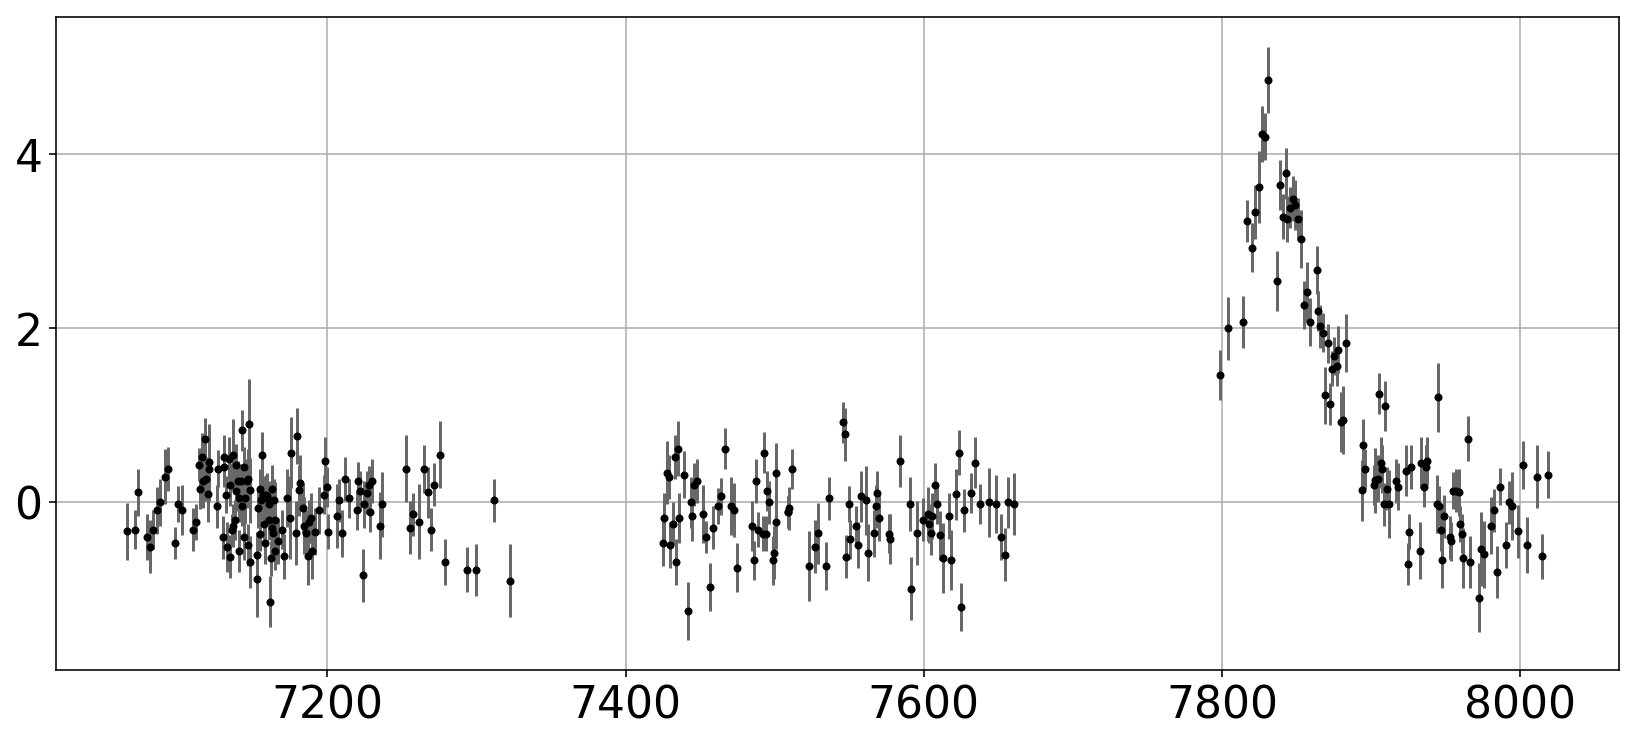

In [2]:
def plot_data(ax, x, y, y_err):
    ax.errorbar(x, y, y_err, fmt='.', color='black', label='Data', ecolor='#686868')
    ax.grid(True)

def magnitudes_to_fluxes(m, sig_m, m0):
    """Given the mean and the standard deviation of a magnitude, assumed to be normally
    distributed, and a reference magnitude m0, this function returns the mean and the 
    standard deviation of a Flux, which is log-normally distributed."""

    e = np.exp(1)
    mu_lnF = m0/(2.5*np.log10(e)) - m
    sig_lnF = sig_m/(2.5*np.log10(e))

    mu_F = np.exp(mu_lnF + 0.5*sig_lnF**2)
    sig_F = np.sqrt((np.exp(sig_lnF**2) - 1)*np.exp(2*mu_lnF + sig_lnF**2))

    return mu_F, sig_F    

def process_data(path_to_data):
    # Load data
    data = pd.read_csv(path_to_data + '/phot.dat', 
                       names=['HJD', 'I_mag', 'I_mag_err', 'seeing_est', 'sky_level'],
                       delim_whitespace=True)
    
    t = (data['HJD'].values - 2450000)
    m = data['I_mag'].values
    m_err = data['I_mag_err'].values
    
    mu_F, sig_F = magnitudes_to_fluxes(m, m_err, 22.)
    
    # Subtract the median from the data such that baseline is at approx zero
    F_r = (mu_F - np.median(mu_F))/np.std(mu_F)
    sig_F_r = sig_F/np.std(mu_F)
        
    return t, F_r, sig_F_r

fig, ax = plt.subplots(figsize=(14,6))
t, F, sigF = process_data('../microlensing_data/OGLE/2017/blg-0305/') #714
plot_data(ax, t, F, sigF)

# Fitting a non-GP model with emcee

In [3]:
def forward_model(pars, t):
    DeltaF, Fb, t0, teff, tE, K = pars
    
    t0 = (t[-1] - t[0])*t0 + t[0]

    u0 = teff/tE

    u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))

    return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

def log_likelihood(pars):

    N = len(F)

    dF = F - forward_model(pars, t)

    return np.sum(-0.5*dF**2/(pars[-1]*sigF)**2)

def log_prior(pars, t, F):
    lnL = 0

    DeltaF, Fb, t0, teff, tE, K = pars
    
    # DeltaF prior
    if DeltaF < 0:
        return -np.inf
    lnL += -(DeltaF - np.max(F))**2/1.**2
    
    # Fb prior
    lnL += -Fb**2/0.1**2
    
    # t0 prior 
    if t0 < 0. or t0 > 1.:
        return -np.inf
    
    # (teff, tE) joint prior
    sig_u0 = 1.
    sig_tE = 365.
    lnL += -np.log(tE) - (teff/tE)**2/sig_u0**2 - tE**2/sig_tE**2
    
    # K prior
    if K < 1:
        return -np.inf
    lnL +=  -(K - 1.)**2/1.**2
    
    if K > 4.:
        return - np.inf

    return lnL

def log_posterior(pars, t, F):
    lnp = log_prior(pars, t, F)
    if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
        return lnp

    lnL = log_likelihood(pars)
    lnprob = lnp + lnL

    if np.isnan(lnprob):
        return -np.inf

    return lnprob

In [ ]:
t0_guess_idx = (np.abs(F - np.max(F))).argmin()

initial = [np.max(F), 0., (t[t0_guess_idx] - t[0])/(t[-1] - t[0]), 0.1, 10., 1.1]

ndim, nwalkers = len(initial), 50
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t,F))

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 5000);

In [4]:
def plot_traceplots(sampler):
    n_pars = len(sampler.flatchain[0, :])
    fig, ax = plt.subplots(n_pars, sharex=True, figsize=(15,10))
    
    mask = sampler.acceptance_fraction > 0.01

    fig.subplots_adjust(hspace=0.08)

#     labels = [r'$F_S$', r'$F_B$',r'$t_0$',r'$u_0$',r'$t_E$']
    for i in range(n_pars):
        tmp = sampler.chain[mask, ::1, i].T
        ax[i].plot(np.arange(len(tmp)), tmp, 'k-', alpha=0.2);
#         ax[i].set_ylabel(labels[i])    

    for a in ax.ravel():
        a.grid(True)

    ax[-1].set_xlabel('steps')
    
plot_traceplots(sampler)

NameError: name 'sampler' is not defined

In [ ]:
# Plot the data.
fig, ax = plt.subplots(figsize=(8, 6))

plot_data(ax, t, F, sigF)

t_ = np.linspace(t[0], t[-1], 1000)

samples = sampler.chain[sampler.acceptance_fraction > 0.05, 2000::1].reshape((-1, 6))
for s in samples[np.random.randint(len(samples), size=50)]:
#     ax.plot(t_, mu, color=color, alpha=0.3)
    ax.plot(t_, forward_model(s, t_), 
             marker='', linestyle='-', color='C0', alpha=0.3, zorder=-10)

ax.grid(True)
# ax.set_xlim(7700, 8000)
# ax.set_xlim(7500, 8000)
# ax.set_ylim(-0.1, 1.1)

In [ ]:
import corner
fig = corner.corner(samples, labels=['$\Delta F$', '$F_b$', '$t_0$', '$t_{eff}$', '$t_E$', '$K$'])
fig.constrained_layout = True

# GP model with a single SHO kernel

In [5]:
from celerite.modeling import Model
from celerite import terms

class PointSourcePointLensGP(Model):
    parameter_names = ("DeltaF", "Fb", "t0", "teff", "tE")

    def get_value(self, t):
        DeltaF = self.DeltaF
        Fb = self.Fb
        t0 = self.t0
        teff = self.teff
        tE = self.tE
        
        u0 = teff/tE
        u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
            
        A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))  
        
        return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb

In [8]:
# Set up mean model
t0_guess_idx = (np.abs(F - np.max(F))).argmin()

mean_model = PointSourcePointLensGP(0., 0., t[t0_guess_idx], 0.1, 10.)

# Set up the GP model

term1 = terms.SHOTerm(log_S0=0., log_Q=0., log_omega0=0.)
term2 = terms.SHOTerm(log_S0=np.log(1), log_Q=np.log(1/np.sqrt(2)), log_omega0=0.)
term2.freeze_parameter('log_S0')
term2.freeze_parameter('log_Q')
kernel = term1 * term2

gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(t, sigF)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(F)))
print(gp.parameter_names)
gp.get_parameter_vector()

Initial log-likelihood: -432.40646551057733
('kernel:k1:log_S0', 'kernel:k1:log_Q', 'kernel:k1:log_omega0', 'kernel:k2:log_S0', 'kernel:k2:log_Q', 'kernel:k2:log_omega0', 'mean:DeltaF', 'mean:Fb', 'mean:t0', 'mean:teff', 'mean:tE')


array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         7.83089962e+03,   1.00000000e-01,   1.00000000e+01])

In [9]:
def log_prior(t, pars):
    lnL = 0

    ln_S0, ln_Q, ln_omega1, ln_omega2, DeltaF, Fb, t0, teff, tE = pars

    if ln_S0 < -15. or ln_S0 > 5.:
        return -np.inf
    if ln_Q < -10. or ln_Q > 15:
        return -np.inf
    if ln_omega1 < -10. or ln_omega2 > 10:
        return -np.inf
    if ln_omega2 < -5. or ln_omega2 > 5:
        return -np.inf
    
    # DeltaF prior
    lnL += -(DeltaF - np.max(F))**2/1.**2
    
    # Fb prior
    lnL += -Fb**2/0.1**2
    
    # t0 prior 
    if t0 < np.min(t) or t0 > np.max(t):
        return -np.inf
    
    # (teff, tE) joint prior
    sig_u0 = 1.
    sig_tE = 365.
    lnL += -np.log(tE) - (teff/tE)**2/sig_u0**2 - tE**2/sig_tE**2
    
    # K prior
#     if K < 1:
#         return -np.inf
#     lnL +=  -(K - 1.)**2/1.**2

    return lnL

def log_posterior(pars, t):    
    gp.set_parameter_vector(pars)
    
    lp = log_prior(t, pars)
    
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(F) + lp + gp.log_prior()

In [10]:
initial_gp = gp.get_parameter_vector()
ndim, nwalkers = len(initial_gp), 50
p0_gp = initial_gp + 1e-8 * np.random.randn(nwalkers, ndim)
sampler_gp = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t,))

print("Running burn-in...")
p0, _, _ = sampler_gp.run_mcmc(p0_gp, 1000)
sampler_gp.reset()

print("Running production...")
sampler_gp.run_mcmc(p0_gp, 5000);

Running burn-in...


/home/fran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


Running production...


/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


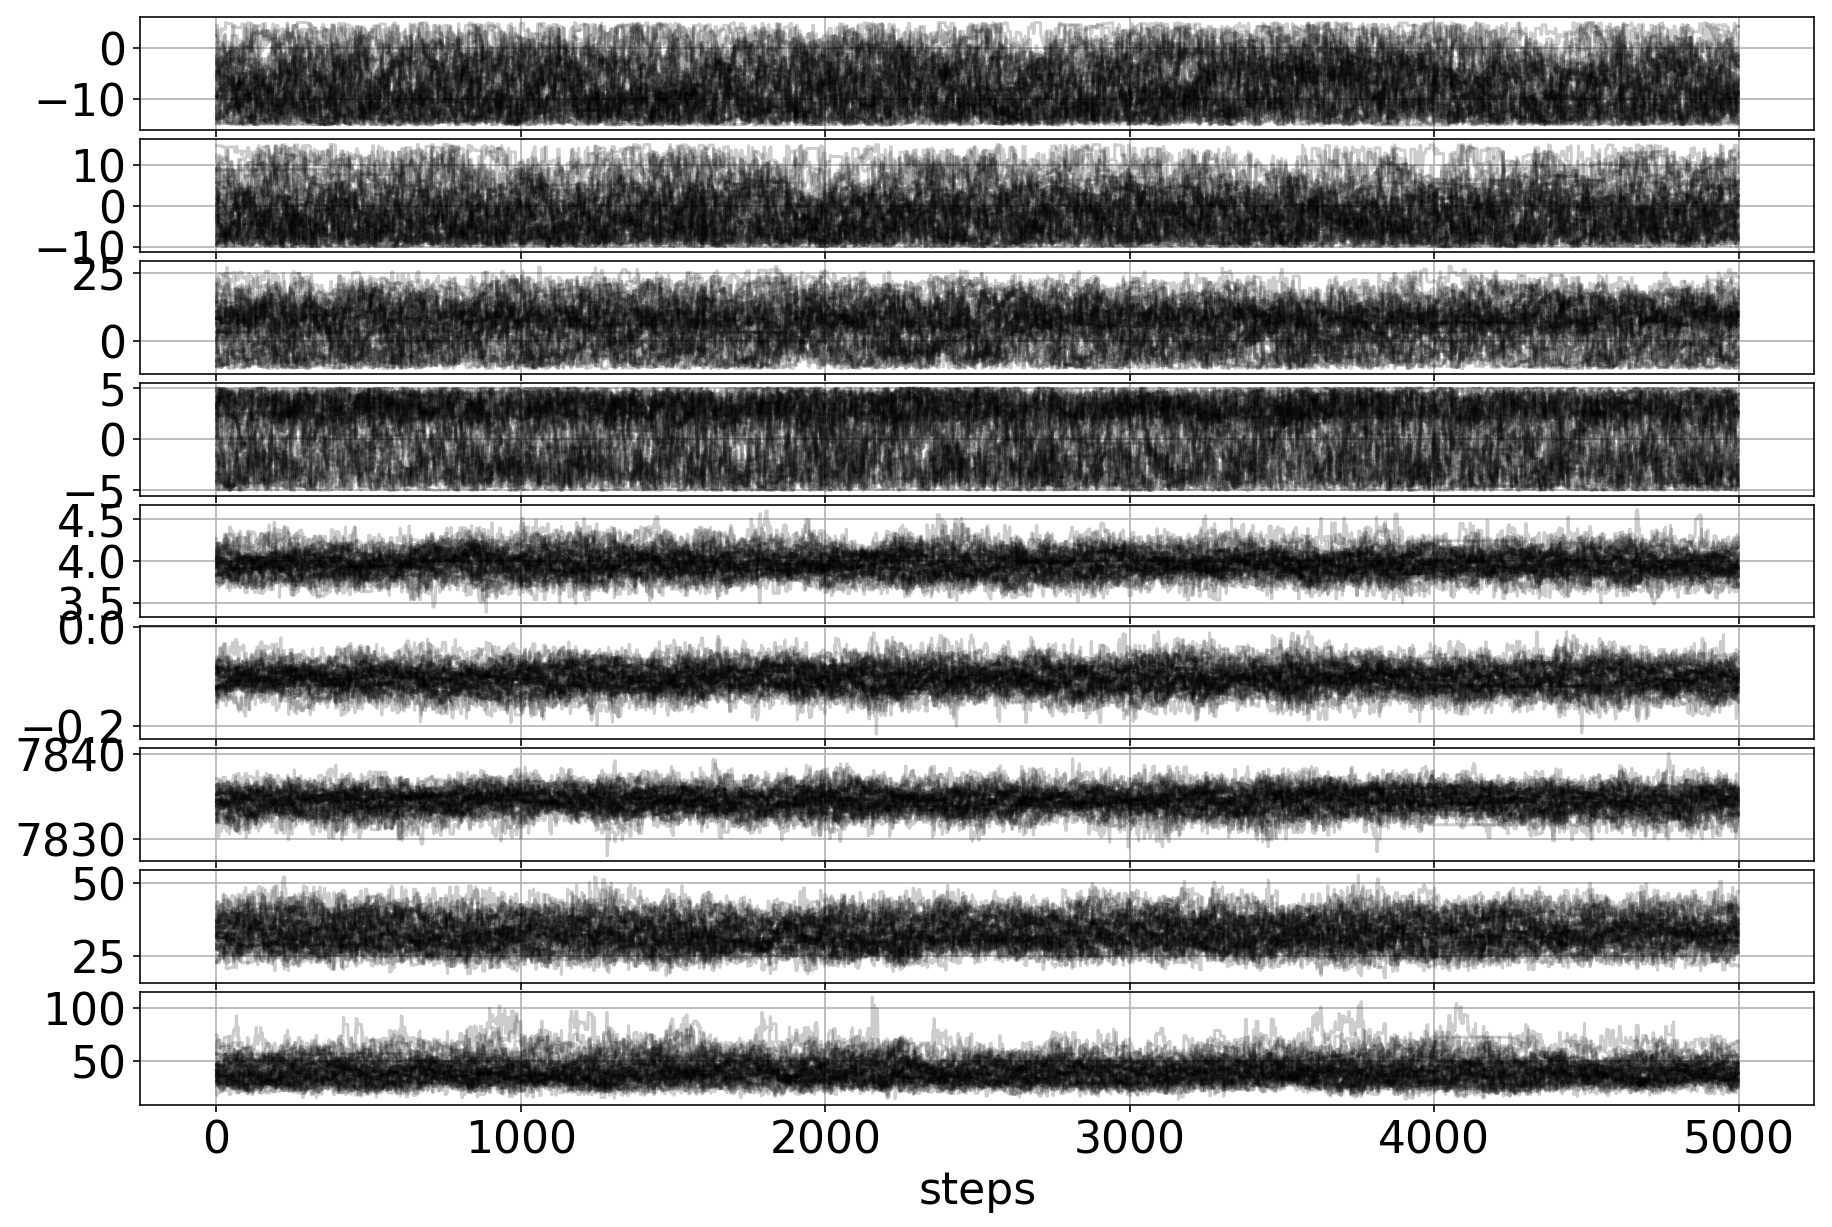

In [11]:
plot_traceplots(sampler_gp)

(7790, 7950)

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


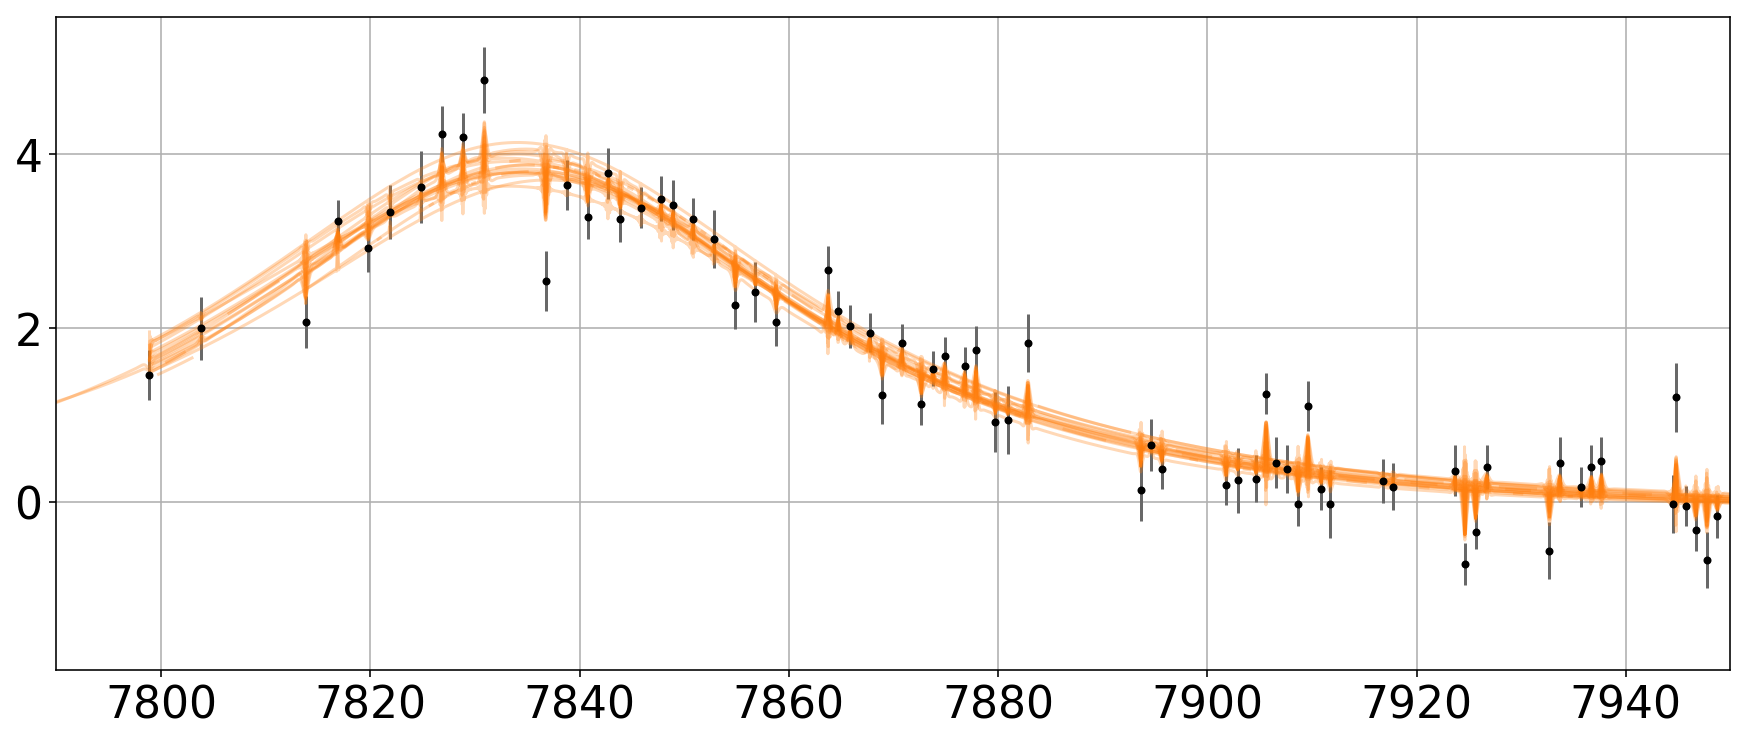

In [12]:
# Plot the data.
fig, ax = plt.subplots(figsize=(15, 6))

plot_data(ax, t, F, sigF)

t_ = np.linspace(7790, 7950, 5000)

# Plot posterior samples from GP model
samples_gp = sampler_gp.chain[sampler_gp.acceptance_fraction > 0.1, :].reshape((-1, 9))
for s in samples_gp[np.random.randint(len(samples_gp), size=50)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(F, t_, return_cov=False)
    plt.plot(t_, mu, color='C1', alpha=0.3)
    
ax.grid(True)
ax.set_xlim(7790, 7950)
# ax.set_ylim(-0.1, 1.1)